## Clustering of False Negatives Based on SHAP Values

This analysis identifies subgroups of false negatives (label = 1, predicted prob < 0.5) using clustering on SHAP values.

### 2. Dimensionality Reduction
- Apply PCA to reduce SHAP dimensions to 2 for visualization.
- Keep components explaining most variance.

### 3. Clustering & Evaluation
- Run `KMeans` for k = 2 to 10.
- Use **silhouette score** to identify optimal cluster number.
- Assign final cluster labels to data.

### 4. Visualization
- **2D scatter plot** of PCA-reduced points colored by cluster.
- **Bar plot**: average SHAP values per feature and cluster.
- **Heatmap**: shows feature importance patterns by cluster.

### Goal
Reveal different types of false negative explanations based on their SHAP signature.


In [84]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns


In [33]:
model = 'transformer'
df = pd.read_csv(f'/Users/I566184/bachelorarbeit_coding/mesogeos/csv/shap_values/shap_{model}_prop_sample_coordinates.csv')

In [34]:
df = df[(df["label"] == 1) & (df["prob"] < 0.5)]
X = df.drop(columns=["sample", "x", "y", "label", "prob", "log_burned_area"])
X

,d2m,dem,lai,lc_agriculture,lc_forest,lc_grassland,lc_settlement,lc_shrubland,lc_sparse_vegetation,lc_water_bodies,...,population,rh,roads_distance,slope,smi,sp,ssrd,t2m,tp,wind_speed
20,0.000778,0.000488,-0.000281,0.000284,-0.000805,0.000019,0.000236,-0.000043,0.000289,0.000000,...,0.000282,-0.001827,0.000032,0.000405,-0.000134,-0.000500,-0.000741,-0.000395,0.000473,-4.474805e-03
26,0.002264,-0.000575,0.000000,-0.000127,0.000000,-0.000161,-0.000061,0.000000,-0.000490,-0.001752,...,-0.000345,-0.000798,-0.000643,-0.000910,-0.000265,-0.000947,-0.000238,-0.001399,-0.000632,8.597757e-07
30,-0.000300,-0.000451,0.000916,-0.000043,-0.000428,-0.000084,-0.000055,-0.000184,-0.000042,0.000000,...,-0.005227,-0.001405,-0.000219,-0.000353,-0.001168,-0.000007,-0.000191,-0.001117,-0.001374,2.427467e-05
31,0.000044,-0.000102,0.000289,0.001547,-0.000579,0.000098,0.000171,0.000624,-0.000646,0.000000,...,0.000150,0.000560,0.000396,0.000416,0.000159,0.000108,-0.000750,-0.001163,0.000273,-3.151933e-03
34,-0.002240,-0.000838,-0.000857,0.002848,0.001615,-0.000038,-0.000187,0.000471,-0.000766,0.000000,...,0.001169,-0.001317,0.000293,0.000112,0.001429,0.000633,0.002418,0.000159,-0.000933,9.353199e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4051,0.004311,0.004477,0.000110,0.000094,0.002673,0.000163,-0.000566,-0.000907,0.001197,0.000000,...,0.000261,0.000738,-0.000267,0.000505,-0.001619,-0.000384,0.000884,-0.002737,-0.002569,-1.147488e-03
4079,-0.002477,-0.000040,-0.001201,0.000053,0.000249,-0.000013,-0.000365,-0.000118,-0.000013,0.000000,...,-0.000553,0.001451,0.000264,-0.000099,-0.001043,0.000458,-0.001332,0.000902,-0.000351,-3.536038e-03
4093,-0.003225,-0.000792,-0.000082,0.000299,0.000113,0.000126,0.001431,-0.000168,0.000308,0.000000,...,0.000965,-0.006902,0.000910,0.000372,0.000511,0.001104,0.000433,0.000430,0.001553,4.354050e-04
4097,0.002192,-0.000464,0.000418,0.000681,0.000701,0.000630,0.000519,-0.000289,0.000268,0.000000,...,-0.000076,-0.002051,0.000296,0.000156,0.001434,0.000440,0.000097,-0.000815,-0.005066,1.421730e-04


In [35]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[ 0.24540693,  0.31308134, -0.10196116, ..., -0.11512862,
         0.49251375, -2.0960556 ],
       [ 0.79014102, -0.41807561,  0.178853  , ..., -0.69318068,
        -0.13211092,  0.09825245],
       [-0.14997365, -0.33271773,  1.09446667, ..., -0.53093393,
        -0.55185099,  0.1097322 ],
       ...,
       [-1.22237694, -0.56758012,  0.09659615, ...,  0.35976797,
         1.10303306,  0.31129924],
       [ 0.76383349, -0.3419202 ,  0.59673473, ..., -0.35701214,
        -2.63929027,  0.16753481],
       [-0.41005838,  0.74227646, -0.00754915, ..., -0.06029565,
        -0.35711299,  0.41812786]])

In [71]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print(f"Reduziert von {X.shape[1]} auf {X_pca.shape[1]} PCA-Komponenten.")

Reduziert von 24 auf 2 PCA-Komponenten.


In [72]:
silhouette_scores = []
K = range(2, 11)  # teste Clusteranzahl von 2 bis 10

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_pca)
    score = silhouette_score(X_pca, labels)
    silhouette_scores.append(score)
    print(f"Anzahl Cluster: {k}, Silhouette Score: {score:.3f}")

Anzahl Cluster: 2, Silhouette Score: 0.355
Anzahl Cluster: 3, Silhouette Score: 0.416
Anzahl Cluster: 4, Silhouette Score: 0.336
Anzahl Cluster: 5, Silhouette Score: 0.331
Anzahl Cluster: 6, Silhouette Score: 0.304
Anzahl Cluster: 7, Silhouette Score: 0.313
Anzahl Cluster: 8, Silhouette Score: 0.314
Anzahl Cluster: 9, Silhouette Score: 0.319
Anzahl Cluster: 10, Silhouette Score: 0.318


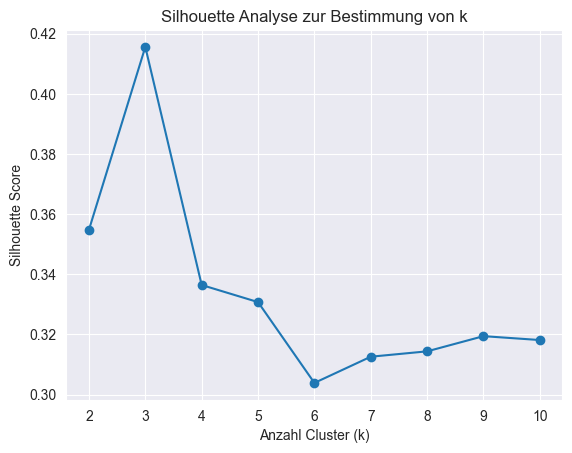

In [73]:
plt.plot(K, silhouette_scores, marker='o')
plt.xlabel("Anzahl Cluster (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analyse zur Bestimmung von k")
plt.grid(True)
plt.show()

In [80]:
optimal_k = K[np.argmax(silhouette_scores)]
print(f"Beste Clusteranzahl laut Silhouette: {optimal_k}")
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42)
labels = kmeans_final.fit_predict(X_pca)
df["cluster"] = labels
df

Beste Clusteranzahl laut Silhouette: 3


,d2m,dem,lai,lc_agriculture,lc_forest,lc_grassland,lc_settlement,lc_shrubland,lc_sparse_vegetation,lc_water_bodies,...,t2m,tp,wind_speed,x,y,label,sample,prob,log_burned_area,cluster
20,0.000778,0.000488,-0.000281,0.000284,-0.000805,0.000019,0.000236,-0.000043,0.000289,0.000000,...,-0.000395,0.000473,-4.474805e-03,4.485050,44.708755,1,3913,0.153535,4.465908,1
26,0.002264,-0.000575,0.000000,-0.000127,0.000000,-0.000161,-0.000061,0.000000,-0.000490,-0.001752,...,-0.001399,-0.000632,8.597757e-07,30.754997,38.143786,1,4893,0.002908,3.713572,1
30,-0.000300,-0.000451,0.000916,-0.000043,-0.000428,-0.000084,-0.000055,-0.000184,-0.000042,0.000000,...,-0.001117,-0.001374,2.427467e-05,15.379678,41.154408,1,3748,0.253121,3.970292,1
31,0.000044,-0.000102,0.000289,0.001547,-0.000579,0.000098,0.000171,0.000624,-0.000646,0.000000,...,-0.001163,0.000273,-3.151933e-03,2.733049,36.029302,1,8442,0.324038,3.850147,0
34,-0.002240,-0.000838,-0.000857,0.002848,0.001615,-0.000038,-0.000187,0.000471,-0.000766,0.000000,...,0.000159,-0.000933,9.353199e-04,24.502166,35.243922,1,6562,0.187394,3.912023,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4051,0.004311,0.004477,0.000110,0.000094,0.002673,0.000163,-0.000566,-0.000907,0.001197,0.000000,...,-0.002737,-0.002569,-1.147488e-03,-6.188060,42.694961,1,1601,0.285569,3.912023,2
4079,-0.002477,-0.000040,-0.001201,0.000053,0.000249,-0.000013,-0.000365,-0.000118,-0.000013,0.000000,...,0.000902,-0.000351,-3.536038e-03,16.386575,40.721443,1,2976,0.117642,3.610918,1
4093,-0.003225,-0.000792,-0.000082,0.000299,0.000113,0.000126,0.001431,-0.000168,0.000308,0.000000,...,0.000430,0.001553,4.354050e-04,13.224918,41.547098,1,3743,0.201522,4.330733,0
4097,0.002192,-0.000464,0.000418,0.000681,0.000701,0.000630,0.000519,-0.000289,0.000268,0.000000,...,-0.000815,-0.005066,1.421730e-04,19.820094,41.859236,1,6090,0.010795,3.688879,2


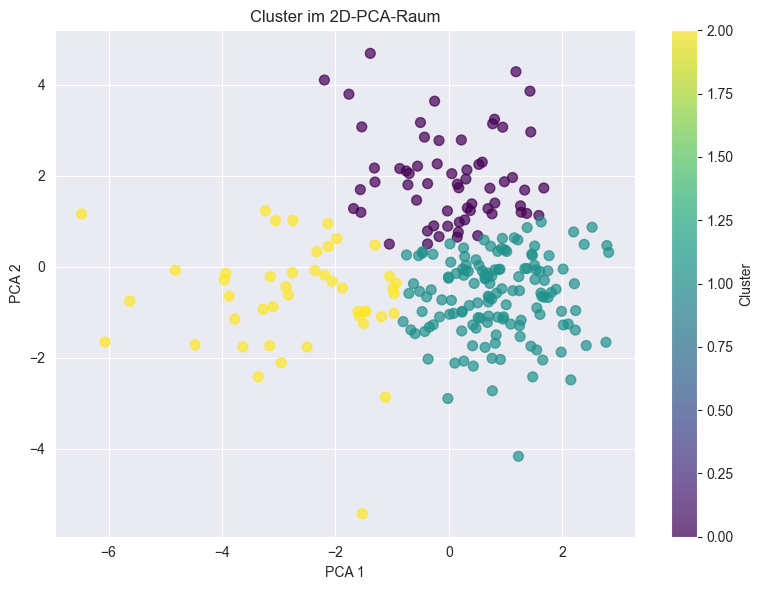

In [81]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap="viridis", s=50, alpha=0.7)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Cluster im 2D-PCA-Raum")
plt.colorbar(label="Cluster")
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

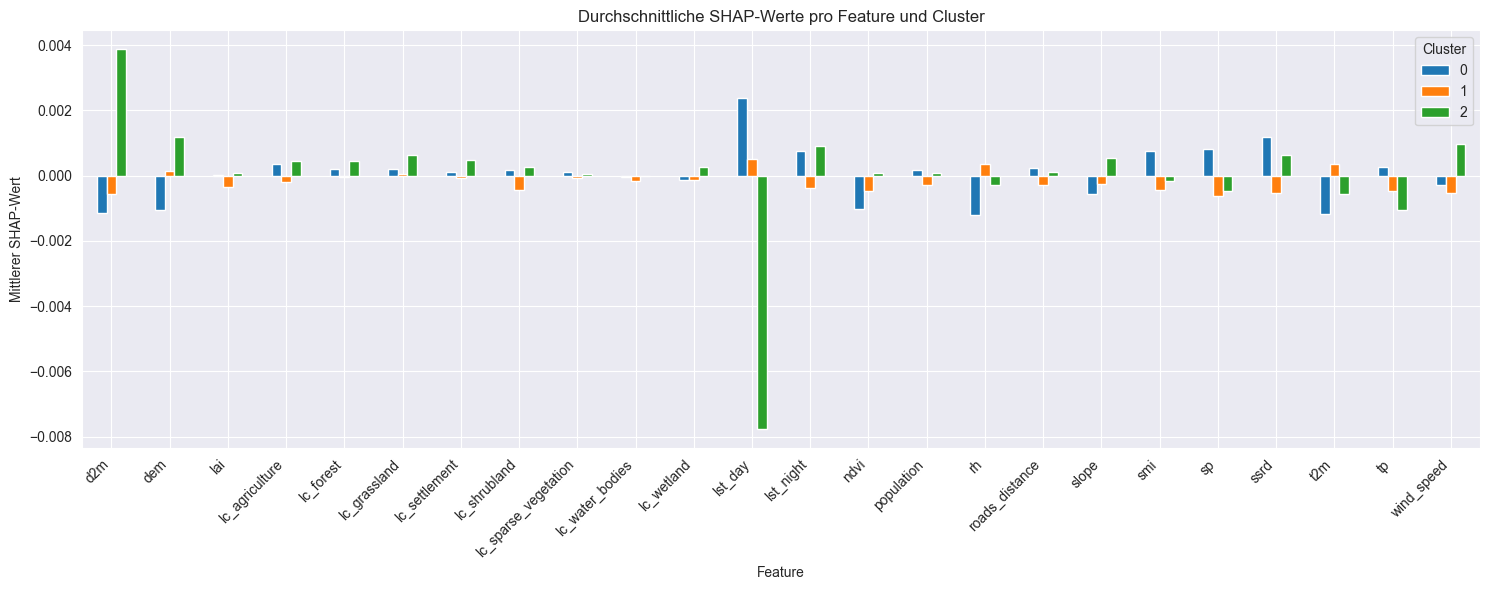

In [82]:
shap_cols = [col for col in df.columns if col not in ["sample", "x", "y", "label", "prob", "log_burned_area", "PCA1", "PCA2", "cluster"]]

cluster_means = df.groupby("cluster")[shap_cols].mean()

cluster_means_T = cluster_means.T

plt.figure(figsize=(12, 6))
cluster_means_T.plot(kind="bar", figsize=(15, 6))
plt.title("Durchschnittliche SHAP-Werte pro Feature und Cluster")
plt.ylabel("Mittlerer SHAP-Wert")
plt.xlabel("Feature")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

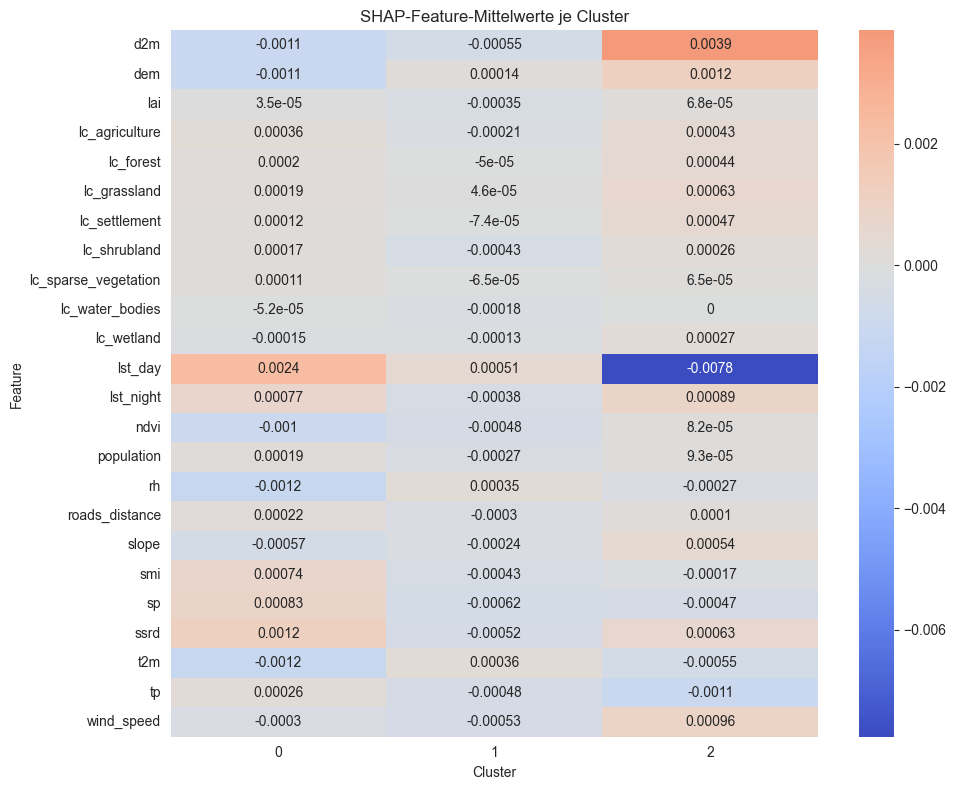

In [85]:
plt.figure(figsize=(10, 8))
sns.heatmap(cluster_means_T, annot=True, center=0, cmap="coolwarm")
plt.title("SHAP-Feature-Mittelwerte je Cluster")
plt.xlabel("Cluster")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()